In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
train_data = np.load('/kaggle/input/distracted-driver/train_statefarm_images.npz')
test_data = np.load('/kaggle/input/distracted-driver/test_statefarm_images.npz')
train_set = torch.tensor(train_data['X'])
train_targets = torch.tensor(train_data['y'])
test_set = torch.tensor(test_data['X'])
test_targets = torch.tensor(test_data['y'])
print("Train set: ", train_set.shape)
print("Test set: ", test_set.shape)
print("Train targets: ", train_targets.shape)
print("Test targets: ", test_targets.shape)

Train set:  torch.Size([17939, 64, 64, 3])
Test set:  torch.Size([4485, 64, 64, 3])
Train targets:  torch.Size([17939])
Test targets:  torch.Size([4485])


In [4]:
from sklearn.model_selection import train_test_split

# Combine train and test data
X_combined = torch.cat([train_set, test_set], dim=0)
y_combined = torch.cat([train_targets, test_targets], dim=0)

print(f"\nCombined data shape: {X_combined.shape}")
print(f"Combined targets shape: {y_combined.shape}")

# Convert to numpy for stratified split
X_combined_np = X_combined.to('cpu').numpy()
y_combined_np = y_combined.to('cpu').numpy()

# Create stratified train-test split (80-20)
X_train_new, X_test_new, y_train_new, y_test_new = train_test_split(
    X_combined_np, 
    y_combined_np, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_combined_np
)

# Convert back to torch tensors
train_set = torch.from_numpy(X_train_new).to(device)
test_set = torch.from_numpy(X_test_new).to(device)
train_targets = torch.from_numpy(y_train_new).to(device)
test_targets = torch.from_numpy(y_test_new).to(device)

print(f"\nNew train set shape: {train_set.shape}")
print(f"New test set shape: {test_set.shape}")
print(f"New train targets shape: {train_targets.shape}")
print(f"New test targets shape: {test_targets.shape}")


Combined data shape: torch.Size([22424, 64, 64, 3])
Combined targets shape: torch.Size([22424])

New train set shape: torch.Size([17939, 64, 64, 3])
New test set shape: torch.Size([4485, 64, 64, 3])
New train targets shape: torch.Size([17939])
New test targets shape: torch.Size([4485])


In [5]:
train_set = train_set.permute(0,3,1,2)
test_set = test_set.permute(0,3,1,2)

train_set = train_set.to(device)
train_targets = train_targets.to(device)
test_set = test_set.to(device)
test_targets = test_targets.to(device)

In [6]:
import torch.nn.functional as F

class CNNNetwork(nn.Module):
    def __init__(self, input_channels=3):
        super(CNNNetwork, self).__init__()
        self.input_channels = input_channels

        self.conv_1 = nn.Conv2d(input_channels, 64, 5, stride = 2)
        self.conv_2 = nn.Conv2d(64, 128, 5, stride = 2)
        self.avg_pool = nn.AvgPool2d(4, stride = 1)
        self.conv_3 = nn.Conv2d(128, 128, 3, stride = 2)
        self.fc_1 = nn.Linear(128*4*4, 1024)
        self.fc_2 = nn.Linear(1024, 10)
        self.dropout = nn.Dropout(p=0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.dropout(self.relu(self.conv_1(x)))
        x = self.dropout(self.relu(self.conv_2(x)))
        x = self.avg_pool(x)
        x = self.dropout(self.relu(self.conv_3(x)))
        x = x.flatten(1)
        x = self.dropout(self.relu(self.fc_1(x)))
        x = self.fc_2(x)
        return x

In [7]:
from torch.optim import Adam

model = CNNNetwork()
model.load_state_dict(torch.load('/kaggle/working/cnn_model_weights.pth'))
model = model.to(device)

optimizer = Adam(model.parameters(), lr = 1e-3, weight_decay = 1e-4)

In [ ]:
loss_per_epoch = []
test_loss_per_epoch = []

def ffnet_training(epochs, batch_size):
    for epoch in range(epochs):
        model.train()
        overall_loss = 0
        overall_test_loss = 0
        idx = torch.randperm(train_set.size(0))
        epoch_set = train_set[idx]
        epoch_targets = train_targets[idx]
        batch_idx = 0
        test_batch_idx = 0
        for j in range(0, train_set.size(0), batch_size):
            batch_arr = epoch_set[j:j+batch_size] / 255.0
            batch_targets = epoch_targets[j:j+batch_size]
            batch_targets = batch_targets

            optimizer.zero_grad()

            outputs = model(batch_arr)
            loss = F.cross_entropy(outputs, batch_targets, reduction = 'mean')
            loss.backward()
            optimizer.step()
            overall_loss += loss.item()
            batch_idx += 1

        model.eval()
        with torch.no_grad():
            for j in range(0, test_set.size(0), batch_size):
                batch_arr = test_set[j:j+batch_size] / 255.0
                batch_targets = test_targets[j:j+batch_size]
                batch_targets = batch_targets

                outputs = model(batch_arr)
                loss = F.cross_entropy(outputs, batch_targets, reduction = 'mean')
                overall_test_loss += loss.item()
                test_batch_idx += 1

        loss_per_epoch.append(overall_loss/batch_idx)
        test_loss_per_epoch.append(overall_test_loss/test_batch_idx)

        if (epoch+1) % 5 == 0:
            print("Epoch {}:".format(epoch+1))
            print("Train loss: {}".format(overall_loss/batch_idx))
            print("Test loss: {}".format(overall_test_loss/test_batch_idx))
            print()

ffnet_training(50, 512)
PATH = "cnn_model_weights.pth"
torch.save(model.state_dict(), PATH)

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(range(1, len(loss_per_epoch) + 1), loss_per_epoch)
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(range(1, len(test_loss_per_epoch) + 1), test_loss_per_epoch)
plt.title('Test Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()


✅ Overall Accuracy: 98.10%

📊 Per-Class Accuracy:
Class 0: 97.79%  (487/498)
Class 1: 99.34%  (450/453)
Class 2: 98.92%  (459/464)
Class 3: 98.72%  (463/469)
Class 4: 99.14%  (461/465)
Class 5: 98.92%  (458/463)
Class 6: 98.49%  (458/465)
Class 7: 99.00%  (396/400)
Class 8: 91.62%  (350/382)
Class 9: 98.12%  (418/426)


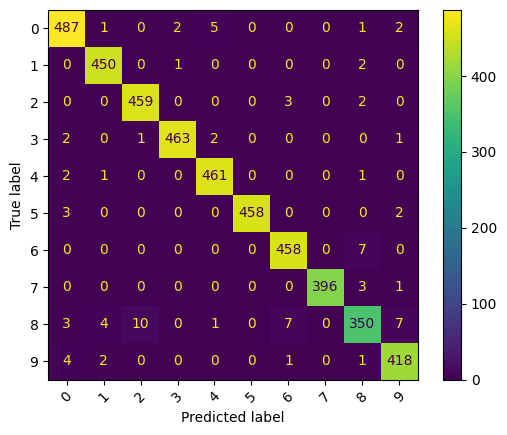

In [8]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def evaluate_model(model, test_set, test_targets, device='cuda'):
    model.eval()
    n_classes = len(torch.unique(test_targets))
    correct_per_class = [0] * n_classes
    total_per_class = [0] * n_classes
    correct_total = 0
    total = 0

    all_preds = []
    all_labels = []

    with torch.no_grad():
        for i in range(0, len(test_set), 128):  # mini-batch eval to save memory
            x_batch = test_set[i:i+128].to(device)
            x_batch = x_batch / 255.0
            y_batch = test_targets[i:i+128].to(device)

            outputs = model(x_batch)
            _, preds = torch.max(outputs, 1)

            correct_total += (preds == y_batch).sum().item()
            total += y_batch.size(0)

            for c in range(n_classes):
                class_mask = (y_batch == c)
                correct_per_class[c] += ((preds == y_batch) & class_mask).sum().item()
                total_per_class[c] += class_mask.sum().item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # overall accuracy
    overall_acc = 100 * correct_total / total
    print(f"\n✅ Overall Accuracy: {overall_acc:.2f}%")

    # per-class accuracy
    print("\n📊 Per-Class Accuracy:")
    for i in range(n_classes):
        acc = 100 * correct_per_class[i] / total_per_class[i]
        print(f"Class {i}: {acc:.2f}%  ({correct_per_class[i]}/{total_per_class[i]})")

    # optional confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(xticks_rotation=45)

# Example usage:
evaluate_model(model, test_set, test_targets, device)